In [155]:
# import libraries
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import matplotlib_inline.backend_inline
from torch.utils.data import DataLoader,TensorDataset
from sklearn.model_selection import train_test_split
import torch.nn.functional as F

matplotlib_inline.backend_inline.set_matplotlib_formats('svg')

In [156]:
data = pd.read_csv('cleaned_merged_heart_dataset.csv')

In [157]:
data.shape

(1888, 14)

# Re-organize the data: train/test in DataLoaders

In [158]:
### z-score all variables except for quality

# find the columns we want to normalize (all except quality)
cols2zscore = data.keys()
cols2zscore = cols2zscore.drop('target')

# z-score (written out for clarity)
for col in cols2zscore:
  meanval   = np.mean(data[col])
  stdev     = np.std(data[col],ddof=1)
  data[col] = (data[col]-meanval) / stdev

# create a new column for binarized (boolean) quality
data['heartD'] = 0
data['heartD'][data['target']>0] = 1

    

/var/folders/lz/zsz00k2n3pbflxxlfqttyt500000gn/T/ipykernel_2656/1041058109.py:15: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  data['heartD'][data['target']>0] = 1
/var/folders/lz/zsz00k2n3pbflxxlfqttyt500000gn/T/ipykernel_2656/1041058109.p

In [159]:
# convert from pandas dataframe to tensor
dataT  = torch.tensor( data[cols2zscore].values ).float()
labels = torch.tensor( data['target'].values ).float()

print( dataT.shape )
print( labels.shape )
# we'll actually need the labels to be a "tensor"
labels = labels[:,None]
print( labels.shape )

torch.Size([1888, 13])
torch.Size([1888])
torch.Size([1888, 1])


In [160]:
# use scikitlearn to split the data
train_data,test_data, train_labels,test_labels = train_test_split(dataT, labels, test_size=.1)


# then convert them into PyTorch Datasets (note: already converted to tensors)
train_dataDataset = TensorDataset(train_data,train_labels)
test_dataDataset  = TensorDataset(test_data,test_labels)


# finally, translate into dataloader objects
batchsize    = 32
train_loader = DataLoader(train_dataDataset,batch_size=batchsize,shuffle=True)
test_loader  = DataLoader(test_dataDataset,batch_size=test_dataDataset.tensors[0].shape[0])

In [161]:
# Pour le train_loader
for batch_idx, (data, labels) in enumerate(train_loader):
    print("--- Batch d'entraînement ---")
    print(f"Index du batch : {batch_idx}")
    print(f"Shape des données (batch) : {data.shape}")
    print(f"Shape des labels (batch) : {labels.shape}")
    print(f"Exemple de données du batch :\n{data[:5]}")  # Afficher les 5 premiers exemples
    print(f"Exemple de labels du batch :\n{labels[:5]}") # Afficher les 5 premiers labels
    break # Ne récupérer que le premier batch

--- Batch d'entraînement ---
Index du batch : 0
Shape des données (batch) : torch.Size([32, 13])
Shape des labels (batch) : torch.Size([32, 1])
Exemple de données du batch :
tensor([[ 0.4014,  0.6724, -0.9986,  0.8231, -0.5591, -0.4172,  0.6301, -1.9310,
         -0.7041,  0.8148, -0.6805,  0.2644,  0.2699],
        [ 0.4014, -1.4865, -0.2179,  0.2535,  1.3979,  2.3958, -0.9353,  0.1120,
         -0.7041, -0.9074,  0.9335,  1.2489, -0.5301],
        [ 0.1812,  0.6724, -0.9986, -0.3730,  0.0416,  2.3958, -0.9353, -0.2358,
          1.4195,  0.1259, -0.6805,  0.2644, -0.5301],
        [ 0.6217,  0.6724, -0.9986, -0.0882,  0.1191, -0.4172,  0.6301, -0.2358,
          1.4195,  0.2981,  0.9335,  0.2644,  0.2699],
        [-1.5806,  0.6724, -0.9986, -1.2274, -1.5473, -0.4172, -0.9353, -1.5398,
          1.4195,  0.8148, -0.6805, -0.7201,  0.2699]])
Exemple de labels du batch :
tensor([[0.],
        [0.],
        [0.],
        [0.],
        [0.]])


In [162]:
print(len(train_loader))

54


On a 54 Batch de 32 patients avec chacun 13 caractéristiques

# The model

In [163]:
def createANNmodel():
    # Modèle d'architecture simplifiée avec dropout pour la régularisation   
    ANNclassify = nn.Sequential(
        nn.Linear(13, 16),      # couche d'entrée
        nn.ReLU(),              # fonction d'activation
        nn.Dropout(0.2),        # régularisation
        nn.Linear(16, 8),       # première couche cachée
        nn.ReLU(),              # fonction d'activation
        nn.Dropout(0.2),        # régularisation
        nn.Linear(8, 1),        # couche de sortie
    )
    
    # fonction de perte
    lossfun = nn.BCEWithLogitsLoss()
    
    # optimiseur avec taux d'apprentissage réduit et weight decay
    optimizer = torch.optim.Adam(ANNclassify.parameters(), lr=0.001, weight_decay=1e-5)
    
    return ANNclassify, lossfun, optimizer

In [164]:
# Test the model input / output

# Test the model 
net, _, _ = createANNmodel()  
test_input = torch.randn(10, 13)     
test_output = net(test_input)     
print(f"Input shape: {test_input.shape}, Output shape: {test_output.shape}")

Input shape: torch.Size([10, 13]), Output shape: torch.Size([10, 1])


# Train the model 

In [165]:
def function2trainTheModel():
    # number of epochs
    numepochs = 500
    
    # create a new model
    net, lossfun, optimizer = createANNmodel()
    
    # initialize losses
    losses = torch.zeros(numepochs)
    trainAcc = []
    testAcc = []
    
    # loop over epochs
    for epochi in range(numepochs):
        # loop over training data batches
        batchAcc = []
        batchLoss = []
        
        for X, y in train_loader:
            # Assurer que X et y sont en format float
            X = X.float()
            y = y.float().view(-1, 1)  # Reshape et conversion en float
            
            # forward pass and loss
            yHat = net(X)
            loss = lossfun(yHat, y)
            
            # backprop
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            # loss from this batch
            batchLoss.append(loss.item())
            
            # compute accuracy (pour classification binaire)
            predictions = (torch.sigmoid(yHat) > 0.5).float()  # Convertir logits en prédictions binaires
            accuracyPct = 100 * (predictions == y).float().mean()  # Calcul d'accuracy correct
            batchAcc.append(accuracyPct.item())
        
        # fin de la boucle de batch...
        # maintenant que nous avons entraîné à travers les batches, obtenons leur précision d'entraînement moyenne
        trainAcc.append(np.mean(batchAcc))
        
        # et obtenir les pertes moyennes à travers les batches
        losses[epochi] = np.mean(batchLoss)
        
        # test accuracy
        test_batch_acc = []
        with torch.no_grad():  # désactive autograd
            for X, y in test_loader:  # Itérer sur tous les lots de test
                X = X.float()
                y = y.float().view(-1, 1)
                yHat = net(X)
                predictions = (torch.sigmoid(yHat) > 0.5).float()
                acc = 100 * (predictions == y).float().mean()
                test_batch_acc.append(acc.item())
        
        testAcc.append(np.mean(test_batch_acc))
        
        # Afficher les progrès
        if (epochi+1) % 50 == 0:
            print(f'Epoch {epochi+1}/{numepochs}, Train Loss: {losses[epochi]:.4f}, '
                  f'Train Acc: {trainAcc[-1]:.2f}%, Test Acc: {testAcc[-1]:.2f}%')
    
    # fin des epochs
    # sortie de fonction
    return trainAcc, testAcc, losses, net

In [166]:
# Run the model and show the results!

In [167]:
trainAcc,testAcc,losses,net = function2trainTheModel()

Epoch 50/500, Train Loss: 0.3334, Train Acc: 86.05%, Test Acc: 88.36%
Epoch 100/500, Train Loss: 0.2740, Train Acc: 88.77%, Test Acc: 88.89%
Epoch 150/500, Train Loss: 0.2587, Train Acc: 88.89%, Test Acc: 92.59%
Epoch 200/500, Train Loss: 0.2341, Train Acc: 90.45%, Test Acc: 88.36%
Epoch 250/500, Train Loss: 0.2521, Train Acc: 89.26%, Test Acc: 88.36%
Epoch 300/500, Train Loss: 0.2202, Train Acc: 90.57%, Test Acc: 91.01%
Epoch 350/500, Train Loss: 0.2648, Train Acc: 90.49%, Test Acc: 94.18%
Epoch 400/500, Train Loss: 0.2203, Train Acc: 90.34%, Test Acc: 88.89%
Epoch 450/500, Train Loss: 0.2309, Train Acc: 90.12%, Test Acc: 89.42%
Epoch 500/500, Train Loss: 0.2229, Train Acc: 91.38%, Test Acc: 93.65%


# Plot the results

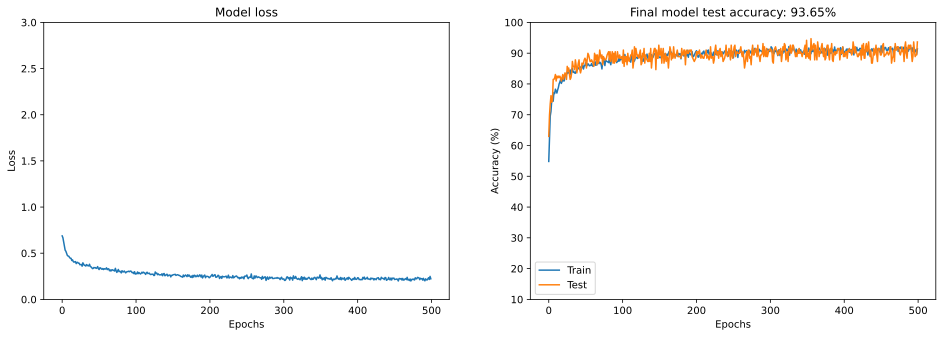

In [168]:

fig,ax = plt.subplots(1,2,figsize=(16,5))

ax[0].plot(losses)
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')
ax[0].set_ylim([0,3])
ax[0].set_title('Model loss')

ax[1].plot(trainAcc,label='Train')
ax[1].plot(testAcc,label='Test')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy (%)')
ax[1].set_ylim([10,100])
ax[1].set_title(f'Final model test accuracy: {testAcc[-1]:.2f}%')
ax[1].legend()

plt.show()